# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [97]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns',None)
scaler = StandardScaler()

df = pd.read_csv("/Users/henryfriesen/LHL_projects/Development_mini/data.csv") 
print(df.shape)
df.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.

In [2]:
# These columns have missing values

df['Gender'].isnull().values.any()
df['Married'].isnull().values.any()
df['Dependents'].isnull().values.any()
df['Self_Employed'].isnull().values.any()
df['LoanAmount'].isnull().values.any()
df['Loan_Amount_Term'].isnull().values.any()
df['Credit_History'].isnull().values.any()

True

In [3]:
print(df['Gender'].isnull().values.sum())
print(df['Married'].isnull().values.sum())
print(df['Dependents'].isnull().values.sum())
print(df['Self_Employed'].isnull().values.sum())
print(df['LoanAmount'].isnull().values.sum())
print(df['Loan_Amount_Term'].isnull().values.sum())
print(df['Credit_History'].isnull().values.sum())

13
3
15
32
22
14
50


Look at some basic statistics for numerical variables.

In [4]:
df[['ApplicantIncome','CoapplicantIncome','LoanAmount']].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,592.000000
mean,5403.459283,1621.245798,146.412162
std,6109.041673,2926.248369,85.587325
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.000000
50%,3812.500000,1188.500000,128.000000
75%,5795.000000,2297.250000,168.000000
max,81000.000000,41667.000000,700.000000


1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)
2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?
3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.



Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

In [5]:
df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [6]:
df[["ApplicantIncome","CoapplicantIncome"]].mean()

ApplicantIncome      5403.459283
CoapplicantIncome    1621.245798
dtype: float64

In [7]:
df[["ApplicantIncome","CoapplicantIncome"]].median()

ApplicantIncome      3812.5
CoapplicantIncome    1188.5
dtype: float64

(array([ 17., 224., 182.,  81.,  29.,  25.,  15.,   7.,   5.,   7.,   6.,
          3.,   5.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  150.,  1767.,  3384.,  5001.,  6618.,  8235.,  9852., 11469.,
        13086., 14703., 16320., 17937., 19554., 21171., 22788., 24405.,
        26022., 27639., 29256., 30873., 32490., 34107., 35724., 37341.,
        38958., 40575., 42192., 43809., 45426., 47043., 48660., 50277.,
        51894., 53511., 55128., 56745., 58362., 59979., 61596., 63213.,
        64830., 66447., 68064., 69681., 71298., 72915., 74532., 76149.,
        77766., 79383., 81000.]),
 <BarContainer object of 50 artists>)

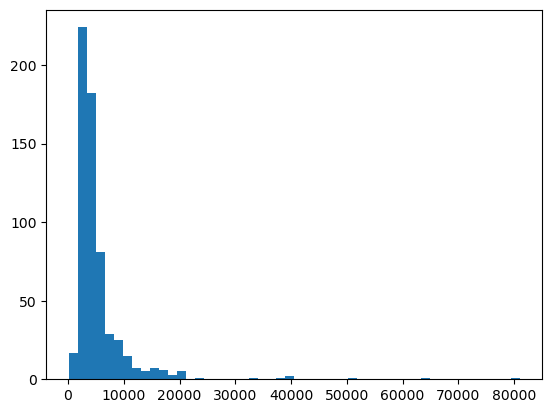

In [8]:

plt.hist(df[["ApplicantIncome"]], bins=50)

(array([289.,  76., 122.,  48.,  26.,  23.,  12.,   2.,   5.,   4.,   1.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([    0.  ,   833.34,  1666.68,  2500.02,  3333.36,  4166.7 ,
         5000.04,  5833.38,  6666.72,  7500.06,  8333.4 ,  9166.74,
        10000.08, 10833.42, 11666.76, 12500.1 , 13333.44, 14166.78,
        15000.12, 15833.46, 16666.8 , 17500.14, 18333.48, 19166.82,
        20000.16, 20833.5 , 21666.84, 22500.18, 23333.52, 24166.86,
        25000.2 , 25833.54, 26666.88, 27500.22, 28333.56, 29166.9 ,
        30000.24, 30833.58, 31666.92, 32500.26, 33333.6 , 34166.94,
        35000.28, 35833.62, 36666.96, 37500.3 , 38333.64, 39166.98,
        40000.32, 40833.66, 41667.  ]),
 <BarContainer object of 50 artists>)

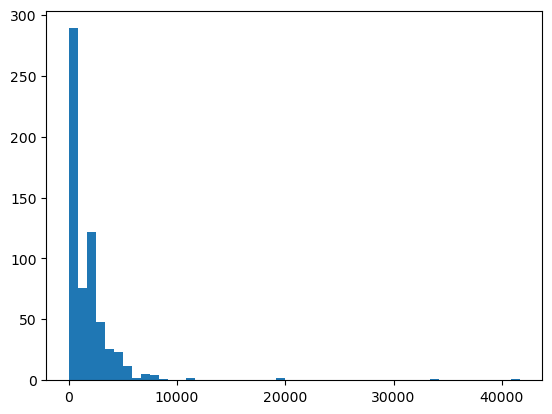

In [9]:
plt.hist(df[["CoapplicantIncome"]], bins=50)

Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

(array([ 2.,  7., 14., 17., 32., 32., 68., 74., 88., 48., 52., 22., 44.,
        14., 11.,  6.,  6.,  7.,  9.,  5.,  4.,  5.,  3.,  1.,  2.,  1.,
         3.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  4.,  3.,  0.,  0.,  0.,
         0.,  1.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([  9.  ,  22.82,  36.64,  50.46,  64.28,  78.1 ,  91.92, 105.74,
        119.56, 133.38, 147.2 , 161.02, 174.84, 188.66, 202.48, 216.3 ,
        230.12, 243.94, 257.76, 271.58, 285.4 , 299.22, 313.04, 326.86,
        340.68, 354.5 , 368.32, 382.14, 395.96, 409.78, 423.6 , 437.42,
        451.24, 465.06, 478.88, 492.7 , 506.52, 520.34, 534.16, 547.98,
        561.8 , 575.62, 589.44, 603.26, 617.08, 630.9 , 644.72, 658.54,
        672.36, 686.18, 700.  ]),
 <BarContainer object of 50 artists>)

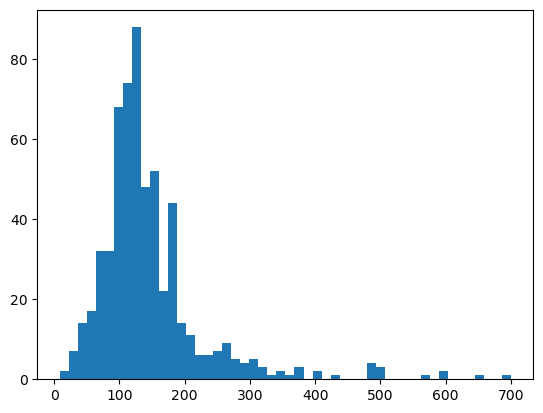

In [10]:
plt.hist(df['LoanAmount'],bins=50)

In [11]:
df['LoanAmount'].describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

### Distribution analysis

Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.



In [12]:
# See above


Look at box plots to understand the distributions. 

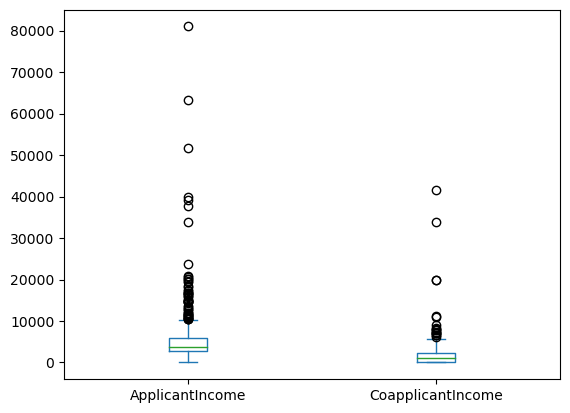

In [13]:
ax = df[['ApplicantIncome', 'CoapplicantIncome']].plot(kind='box')

Look at the distribution of income segregated  by `Education`

In [14]:
education_check = df[['Education','ApplicantIncome','CoapplicantIncome']]
education_check.groupby('Education').describe()

ApplicantIncome                                            \
                       count         mean          std    min      25%   
Education                                                                
Graduate               480.0  5857.433333  6739.797954  150.0  2998.75   
Not Graduate           134.0  3777.283582  2237.081586  210.0  2583.00   

                                       CoapplicantIncome               \
                 50%      75%      max             count         mean   
Education                                                               
Graduate      4000.0  6068.75  81000.0             480.0  1717.474833   
Not Graduate  3357.5  4333.00  18165.0             134.0  1276.544776   

                                                               
                      std  min  25%     50%      75%      max  
Education                                                      
Graduate      3230.965850  0.0  0.0  1059.0  2337.00  41667.0  
Not Graduate  1310.343602  0.0  0.0  1356.5  2028.25   7101.0

Look at the histogram and boxplot of LoanAmount

(array([ 2.,  7., 14., 17., 32., 32., 68., 74., 88., 48., 52., 22., 44.,
        14., 11.,  6.,  6.,  7.,  9.,  5.,  4.,  5.,  3.,  1.,  2.,  1.,
         3.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  4.,  3.,  0.,  0.,  0.,
         0.,  1.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([  9.  ,  22.82,  36.64,  50.46,  64.28,  78.1 ,  91.92, 105.74,
        119.56, 133.38, 147.2 , 161.02, 174.84, 188.66, 202.48, 216.3 ,
        230.12, 243.94, 257.76, 271.58, 285.4 , 299.22, 313.04, 326.86,
        340.68, 354.5 , 368.32, 382.14, 395.96, 409.78, 423.6 , 437.42,
        451.24, 465.06, 478.88, 492.7 , 506.52, 520.34, 534.16, 547.98,
        561.8 , 575.62, 589.44, 603.26, 617.08, 630.9 , 644.72, 658.54,
        672.36, 686.18, 700.  ]),
 <BarContainer object of 50 artists>)

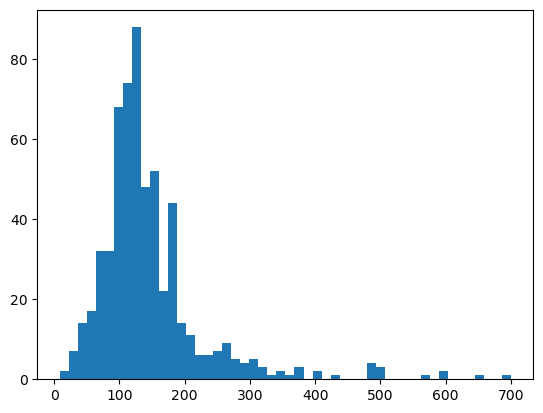

In [15]:
plt.hist(df['LoanAmount'],bins=50)

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

### Categorical variable analysis

Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

In [16]:
table = pd.pivot_table(df, values=['ApplicantIncome', 'LoanAmount'], index=['Gender','Married'],
                       aggfunc={'ApplicantIncome': [min, max, np.mean],
                                'LoanAmount': np.mean})
table

ApplicantIncome                     LoanAmount
                           max         mean   min        mean
Gender Married                                               
Female No                18165  4503.787500   416  116.115385
       Yes               19484  4829.645161   210  153.322581
Male   No                37719  5236.146154  1442  136.088000
       Yes               81000  5529.540616   150  154.011662

## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.



Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

In [17]:
print(df['Gender'].isnull().values.sum())
print(df['Married'].isnull().values.sum())
print(df['Dependents'].isnull().values.sum())
print(df['Self_Employed'].isnull().values.sum())
print(df['LoanAmount'].isnull().values.sum())
print(df['Loan_Amount_Term'].isnull().values.sum())
print(df['Credit_History'].isnull().values.sum())

13
3
15
32
22
14
50


In [18]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [19]:
# check column where Na

df[df['Gender'].isna()]
df.Gender = df.Gender.fillna('Male')

# verfiry change
df[df['Gender'].isna()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


In [20]:
# repeat for rest

df[df['Married'].isnull()]
df.Married = df.Married.fillna('No')
df[df['Married'].isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


In [21]:
df[df['Dependents'].isnull()]
df.Dependents = df.Dependents.fillna('0')

In [22]:
df[df['Self_Employed'].isnull()]
df.Self_Employed = df.Self_Employed.fillna('No')

In [23]:
df[df['LoanAmount'].isnull()]
LoanAmount_Mean = df['LoanAmount'].mean()
df['LoanAmount'].fillna(LoanAmount_Mean, inplace=True)
# df.LoanAmount = df.LoanAmount.fillna(df['LoanAmount'].mean)

In [24]:
df[df['Loan_Amount_Term'].isna()]
df.Loan_Amount_Term = df.Loan_Amount_Term.fillna(df['Loan_Amount_Term'].mode()[0])

In [25]:
df[df['Credit_History'].isna()]
df.Credit_History = df.Credit_History.fillna(0.0)

In [26]:
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].replace(0.0, df['Loan_Amount_Term'].mean())
df['Loan_Amount_Term'].describe()

count    614.000000
mean     342.410423
std       64.428629
min       12.000000
25%      360.000000
50%      360.000000
75%      360.000000
max      480.000000
Name: Loan_Amount_Term, dtype: float64

In [27]:
# Re-check previous columns with Na

print(df['Gender'].isnull().values.sum())
print(df['Married'].isnull().values.sum())
print(df['Dependents'].isnull().values.sum())
print(df['Self_Employed'].isnull().values.sum())
print(df['LoanAmount'].isnull().values.sum())
print(df['Loan_Amount_Term'].isnull().values.sum())
print(df['Credit_History'].isnull().values.sum())

0
0
0
0
0
0
0


### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

(array([ 2.,  7., 14., 17., 32., 32., 68., 74., 88., 70., 52., 22., 44.,
        14., 11.,  6.,  6.,  7.,  9.,  5.,  4.,  5.,  3.,  1.,  2.,  1.,
         3.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  4.,  3.,  0.,  0.,  0.,
         0.,  1.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([  9.  ,  22.82,  36.64,  50.46,  64.28,  78.1 ,  91.92, 105.74,
        119.56, 133.38, 147.2 , 161.02, 174.84, 188.66, 202.48, 216.3 ,
        230.12, 243.94, 257.76, 271.58, 285.4 , 299.22, 313.04, 326.86,
        340.68, 354.5 , 368.32, 382.14, 395.96, 409.78, 423.6 , 437.42,
        451.24, 465.06, 478.88, 492.7 , 506.52, 520.34, 534.16, 547.98,
        561.8 , 575.62, 589.44, 603.26, 617.08, 630.9 , 644.72, 658.54,
        672.36, 686.18, 700.  ]),
 <BarContainer object of 50 artists>)

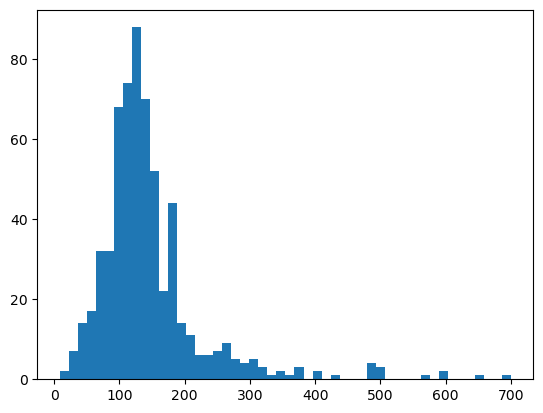

In [28]:
plt.hist(df['LoanAmount'],bins=50)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,
         2.,  0.,  2.,  0.,  3.,  6.,  5.,  8.,  7.,  7., 17., 10., 19.,
        20., 50., 53., 58., 62., 48., 60., 36., 44., 16., 13., 10., 14.,
         8.,  7.,  3.,  6.,  2.,  1.,  4.,  3.,  1.,  2.,  2.]),
 array([3.169925  , 3.29555072, 3.42117645, 3.54680217, 3.67242789,
        3.79805361, 3.92367933, 4.04930506, 4.17493078, 4.3005565 ,
        4.42618222, 4.55180795, 4.67743367, 4.80305939, 4.92868511,
        5.05431083, 5.17993656, 5.30556228, 5.431188  , 5.55681372,
        5.68243945, 5.80806517, 5.93369089, 6.05931661, 6.18494233,
        6.31056806, 6.43619378, 6.5618195 , 6.68744522, 6.81307095,
        6.93869667, 7.06432239, 7.18994811, 7.31557383, 7.44119956,
        7.56682528, 7.692451  , 7.81807672, 7.94370245, 8.06932817,
        8.19495389, 8.32057961, 8.44620533, 8.57183106, 8.69745678,
        8.8230825 , 8.94870822, 9.07433395, 9.19995967, 9.32558539,
        9.45121111]),
 <BarContainer

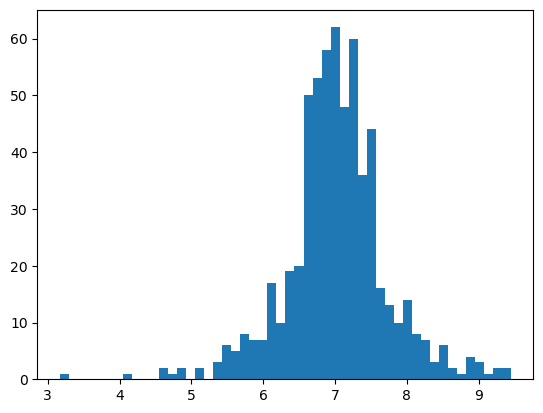

In [29]:
logged_LoanAmount = np.log2(df['LoanAmount'])
plt.hist(logged_LoanAmount, bins=50)

Combine both incomes as total income and take a log transformation of the same.

(array([ 1.,  0.,  1.,  3.,  2.,  6., 12.,  5., 14., 16., 23., 38., 27.,
        39., 59., 45., 40., 48., 40., 32., 23., 19., 16., 15., 18., 15.,
         7.,  7.,  5.,  7.,  8.,  4.,  3.,  2.,  3.,  1.,  1.,  0.,  0.,
         2.,  1.,  2.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([10.49385545, 10.61009103, 10.7263266 , 10.84256218, 10.95879776,
        11.07503333, 11.19126891, 11.30750449, 11.42374006, 11.53997564,
        11.65621122, 11.77244679, 11.88868237, 12.00491795, 12.12115352,
        12.2373891 , 12.35362468, 12.46986025, 12.58609583, 12.70233141,
        12.81856698, 12.93480256, 13.05103814, 13.16727371, 13.28350929,
        13.39974487, 13.51598045, 13.63221602, 13.7484516 , 13.86468718,
        13.98092275, 14.09715833, 14.21339391, 14.32962948, 14.44586506,
        14.56210064, 14.67833621, 14.79457179, 14.91080737, 15.02704294,
        15.14327852, 15.2595141 , 15.37574967, 15.49198525, 15.60822083,
        15.7244564 , 15.84069198, 15.95692756, 16.07316313,

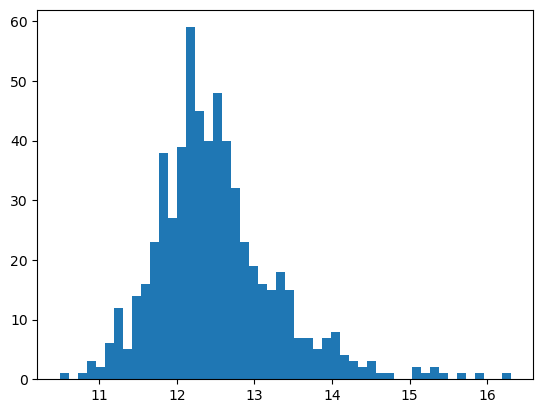

In [30]:
df['Total_Income_Log'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Total_Income_Log'] = np.log2(df['Total_Income_Log'])
df.head()
plt.hist(df['Total_Income_Log'], bins = 50)


## 4. Building a Predictive Model

In [31]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income_Log
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,12.513974
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,12.572463
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,11.550747
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,12.270587
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,12.550747


In [32]:
df['Dependents'].value_counts()

0     360
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [33]:
df['Married'] = df['Married'].replace({'Yes': 'Married',
                                       'No': 'Not Married'})

In [34]:
df.reset_index()
model_df = df.copy()
cat_col = ['Gender', 'Self_Employed', 'Married','Education','Credit_History','Property_Area','Dependents']
num_col = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Total_Income_Log']

y_target = df['Loan_Status'].copy()
model_df.drop('Loan_Status',axis=1, inplace=True)


In [35]:
one_hot = OneHotEncoder(sparse=False,handle_unknown='ignore')

In [36]:
hot_col = one_hot.fit_transform(model_df[cat_col])
encoded_data = pd.DataFrame(hot_col, index=model_df[cat_col].index)
cat_names = np.array(one_hot.categories_)
cat_names = np.concatenate(cat_names)
encoded_data.columns = cat_names
final_model_df = pd.concat([model_df,encoded_data], axis=1)
final_model_df.drop(cat_col,axis=1,inplace=True)
final_model_df.drop('Loan_ID',axis=1,inplace=True)

/var/folders/_v/3xv7lzg50z70knbq7q2fy3980000gn/T/ipykernel_96978/2904780875.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cat_names = np.array(one_hot.categories_)


In [37]:
x_train,x_test,y_train,y_test = train_test_split(final_model_df,y_target,test_size=0.3)

In [38]:
y_train = y_train.replace({'Y':1,
                           'N':0})

In [39]:
# x_train_scaled = scaler.fit_transform(x_train[num_col])
# x_test_scaled = scaler.fit_transform(x_test[num_col])
# x_train[num_col] = x_train_scaled
# x_test[num_col] = x_test_scaled

In [87]:
xgboost = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=50)
xgboost.fit(x_train,y_train)
y_pred = xgboost.predict(x_test)

In [88]:
y_test = y_test.replace({'Y':1,
                           'N':0})

In [89]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Accuracy Score:  0.7027027027027027


Try paramater grid search to improve the results

In [93]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
grid = GridSearchCV(svc, parameters)
grid.fit(x_train, y_train)

# best_model = grid.best_estimator_
# best_hyperparams = grid.best_params_
# best_acc = grid.score(X_test, y_test)
# print(f'Best test set accuracy: {best_acc}\nAchieved with hyperparameters: {best_hyperparams}')

/Users/henryfriesen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/henryfriesen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/henryfriesen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/henryfriesen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', '

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [95]:
best_model = grid.best_estimator_
best_hyperparams = grid.best_params_
best_acc = grid.score(x_test, y_test)
print(f'Best test set accuracy: {best_acc}\nAchieved with hyperparameters: {best_hyperparams}')

Best test set accuracy: 0.7135135135135136
Achieved with hyperparameters: {'C': 10, 'kernel': 'linear'}


/Users/henryfriesen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

In [98]:
# Pipeline without GridSearch

pipeline = Pipeline(steps=[('scaling', StandardScaler()),
                           ('pca', PCA(n_components=3)),
                           ('classifier', LogisticRegression())])
pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {acc}')

Test set accuracy: 0.7081081081081081


/Users/henryfriesen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/henryfriesen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/henryfriesen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [107]:
x_test.head

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Total_Income_Log,Female,Male,No,Yes,Not Married,Graduate,Not Graduate,0.0,1.0,Rural,Semiurban,Urban,0,1,2,3+
318,3541,0.0,112.0,360.0,11.789941,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
516,2031,1632.0,113.0,480.0,11.838810,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
539,6417,0.0,157.0,180.0,12.647683,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
306,3762,1666.0,135.0,360.0,12.406205,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
45,3410,0.0,88.0,360.0,11.735556,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
# parameters = {'kernel':('linear'), 'C':[10]}
# grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)
# grid.fit(x_train, y_train)

# best_model = grid.best_estimator_
# best_hyperparams = grid.best_params_
# best_acc = grid.score(x_test, y_test)
# print(f'Best test set accuracy: {best_acc}\nAchieved with hyperparameters: {best_hyperparams}')

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python

In [102]:
import pickle

picklefile = 'pickled_bank.pkl'
pickle.dump(pipeline, open(picklefile, 'wb'))
